In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
import graphviz
import qiskit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
!pip install graphviz
!pip install pyzx
import pyzx as zx
!pip install js.d3
import fractions

  Using cached pyzx-0.7.0-py3-none-any.whl (295 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached js.d3-3.5.5-py3-none-any.whl
  Using cached fanstatic-1.2-py2.py3-none-any.whl (31 kB)
  Using cached WebOb-1.8.7-py2.py3-none-any.whl (114 kB)
  Using cached shutilwhich-1.1.0-py3-none-any.whl


In [2]:
def _gf_to_circ(gf):
    inp = gf.inputs()
    out=gf.outputs()
    qmap=gf.qubits() 
    nqubits=len(list(set(list(qmap.values()))))
    qmap_inp = [qmap.get(i) for i in inp]
    qmap_out = [qmap.get(i) for i in out]
    only_inp_q = [q for q in qmap_inp if q not in qmap_out]
    only_out_q = [q for q in qmap_out if q not in qmap_inp]
    qc=QuantumCircuit(nqubits)
    if len(only_inp_q+only_out_q)!=0:
        qc.h(only_inp_q+only_out_q)
    ed_gen=[]
    a=gf.edges()
    for i in a:
        ed_gen.append(i)
    for edge in ed_gen:
        if (gf.qubit(edge[0])==gf.qubit(edge[1])):              
            if (isinstance(gf.phase(edge[0]),fractions.Fraction)):
                ph=gf.phase(edge[0])
                qc.rz(ph*np.pi,gf.qubit(edge[0]))
            if (gf.edge_type(edge)==2):
                qc.h(gf.qubit(edge[0]))
            if (isinstance(gf.phase(edge[1]),fractions.Fraction)):
                ph=gf.phase(edge[1])
                qc.rz(ph*np.pi,gf.qubit(edge[1]))
        if (gf.qubit(edge[0])!=gf.qubit(edge[1])):
            if (isinstance(gf.phase(edge[0]),fractions.Fraction)):
                ph=gf.phase(edge[0])
                qc.rz(ph*np.pi,gf.qubit(edge[0]))
            if (gf.edge_type(edge)==2):
                qc.cz(gf.qubit(edge[0]),gf.qubit(edge[1]))
            if (gf.edge_type(edge)==1):
                qc.cx(gf.qubit(edge[0]),gf.qubit(edge[1]))
            if (isinstance(gf.phase(edge[1]),fractions.Fraction)):
                ph=gf.phase(edge[1])
                qc.rz(ph*np.pi,gf.qubit(edge[1]))
    return qc

In [3]:
def _zxcirc_to_qiskit_circ(c2):
    n=c2.qubits
    qc=QuantumCircuit(n)
    for g in c2.gates:
        print(g)
        if g.name == 'SWAP':
            qc.swap(g.control,g.target)
        if g.name == 'HAD':
            qc.h(g.target)
        if g.name == 'ZPhase':
            qc.rz(g.phase*np.pi,g.target)
        if g.name == 'CZ':
            qc.cz(g.control, g.target)
        if g.name == 'CNOT':
            qc.cx(g.control, g.target)
        if g.name == 'S':
            qc.rz(g.phase*np.pi, g.target)
        if g.name == 'T':
            qc.rz(g.phase*np.pi, g.target)
        if g.name == 'XPhase':
            qc.rx(g.phase*np.pi, g.target) 
        if g.name == 'CCZ':
            qc.ccz(g.ctrl1,g.ctrl2,g.target)
        if g.name=='CHAD':
            qc.ch(g.control,g.target)
        if g.name == 'CRZ':
            qc.crz(g.control,g.target,g.phase)
        if g.name=='Tof':
            qc.ccx(g.ctrl1,g.ctrl2,g.target)     
        
    return qc

In [4]:
def clone(gr):
    cpy = zx.Graph()
    for v, d in gr.graph.items():
        cpy.graph[v] = d.copy()
        cpy._vindex = gr._vindex
        cpy.nedges = gr.nedges
        cpy.ty = gr.ty.copy()
        cpy._phase = gr._phase.copy()
        cpy._qindex = gr._qindex.copy()
        cpy._maxq = gr._maxq
        cpy._rindex = gr._rindex.copy()
        cpy._maxr = gr._maxr
        cpy._vdata = gr._vdata.copy()
        cpy.scalar = gr.scalar.copy()
        cpy._inputs = gr._inputs
        cpy._outputs = gr._outputs
        cpy.track_phases = gr.track_phases
        cpy.phase_index = gr.phase_index.copy()
        cpy.phase_master = gr.phase_master
        cpy.phase_mult = gr.phase_mult.copy()
        cpy.max_phase_index = gr.max_phase_index
    return cpy

In [5]:
def zx_to_dag(g):
    if (isinstance(g, zx.circuit.Circuit)):
#         g1=g.to_basic_gates()
        g1 = g.to_graph()
#         zx.simplify.full_reduce(g1)
        zx.simplify.full_reduce(g1)
        g1 = zx.extract_circuit(g1).to_basic_gates()
#         g1 = zx.extract_circuit(g1)
#         qc=_zxcirc_to_qiskit_circ(g1)  
#         dag = circuit_to_dag(qc)
#         return dag
        try:
            g2 = zx.optimize.full_optimize(g1)
        except:
            print('y1')
            qc=_zxcirc_to_qiskit_circ(g1)  
            dag = circuit_to_dag(qc)
            return dag
        else:
            print('y2')
            qc=_zxcirc_to_qiskit_circ(g2)  
            dag = circuit_to_dag(qc)
            return dag
    if isinstance(g,zx.graph.graph_s.GraphS):
        for i in g.qubits().values():
                if isinstance(i,float):
                    print('''for zx graphs, 3 qubit gates and other multi-qubit gates(beyond 2 qubits) are not supported right now.\n Most                              multi-qubit gates can be decomposed into 2 qubits and single qubit gates. We recommend \ndecomposing                                        these gates.''')
                    return
                    break;   
        try:
            new_circ=zx.extract_circuit(g).to_basic_gates()            
        except:
            print('no direct extraction')
            g2=clone(g)
            zx.full_reduce(g2)
            # g2.normalize()
            qmap=g2.qubits()
            if (sum(1 for num in list(qmap.values()) if num < 0)==0):
                print('case 1')
                qc= _gf_to_circ(g2)
                dag = circuit_to_dag(qc)
                return dag
            if (sum(1 for num in list(qmap.values()) if num < 0)>0):
                print('case 2')
                zx.to_gh(g)
                qc= _gf_to_circ(g)
                dag = circuit_to_dag(qc)
                return dag  
        else:
            print('case 3')
            try:
                g2 = zx.optimize.full_optimize(g1)
            except:
                qc=_zxcirc_to_qiskit_circ(g1)  
                dag = circuit_to_dag(qc)
                return dag
            else:
                qc=_zxcirc_to_qiskit_circ(g2)  
                dag = circuit_to_dag(qc)
                return dag

In [6]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate
from typing import List, Callable, Optional, Union

class ZXSwap(TransformationPass):
    """converts from ZX diagrams to Qiskit DAG circuits and DAGs to ZX diagrams"""

    def __init__(self):
        
        super().__init__()

    def run(self, obj: Union[qiskit.circuit.quantumcircuit.QuantumCircuit,zx.graph.graph_s.GraphS, zx.circuit.Circuit,
                            qiskit.dagcircuit.dagcircuit.DAGCircuit]):
        """
        Args:
            obj: Could be ZX circuits or spiders/diagrams or qiskit circuits or qiskit DAGs
        """
        
        if (isinstance(obj,qiskit.circuit.quantumcircuit.QuantumCircuit) or isinstance(obj,qiskit.dagcircuit.dagcircuit.DAGCircuit)):
            print('to be added soon')
        
        if (isinstance(obj,zx.graph.graph_s.GraphS) or isinstance(obj,zx.circuit.Circuit)):
            dag=zx_to_dag(g)

        return dag

<class 'pyzx.graph.graph_s.GraphS'>


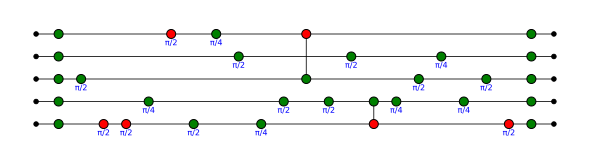

In [7]:
import matplotlib
# %matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import Javascript
import pyzx as zx
qubit_amount = 5
gate_count = 20
g = zx.generate.cliffordT(qubit_amount, gate_count)
print(g.__class__)
zx.draw_matplotlib(g)

In [8]:
ob=ZXSwap()
d=ob.run(g)

case 3
S*(0)
HAD(0)
ZPhase(0,phase=7/4)
ZPhase(1,phase=7/4)
HAD(1)
S*(2)
HAD(2)
CNOT(2,0)
Z(2)
HAD(3)
T(3)
CNOT(3,4)
HAD(4)
ZPhase(4,phase=3/4)
CNOT(3,4)
HAD(4)
HAD(3)
T(3)
HAD(3)
T(3)
HAD(3)


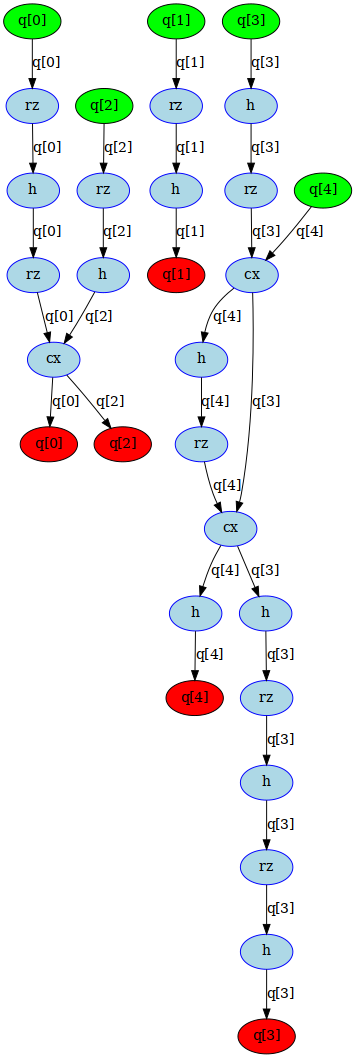

In [9]:
dag_drawer(d)

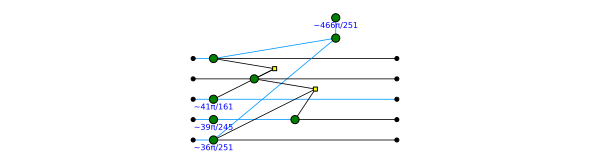

In [10]:
g = zx.sqasm("""
qreg q[5];
h q[0];
rx(0.5) q[3];
rx(0.8) q[2];
h q[4];
ccx q[0],q[1],q[2];
ccz q[1],q[3],q[4];
crz(0.9) q[0], q[4];
""")
zx.full_reduce(g)
zx.draw_matplotlib(g)

In [11]:
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)

3 qubit gates and other multi-qubit gates(beyond 2 qubits) are not supported right now.
 Most multi-qubit gates can be decomposed into 2 qubits and single qubit gates. We recommend 
decomposing these gates.


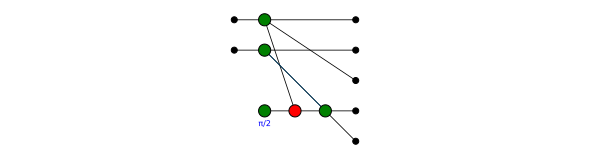

In [12]:
s = """
qreg q[2];
qreg A[3];
s A[1];
cx q[0], A[0];
cx q[0], A[1];
cx q[1], A[2];
cz q[1],A[1];
"""
g=zx.sqasm(s,simplify=True)
zx.draw_matplotlib(g)

In [13]:
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)

no direct extraction
case 1


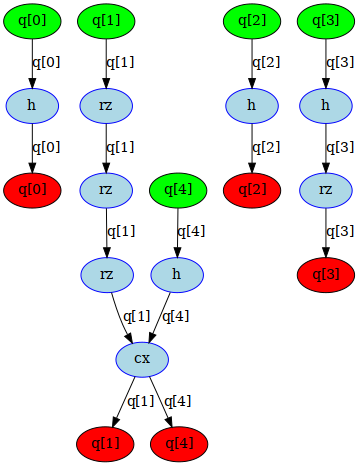

In [14]:
dag_drawer(d)

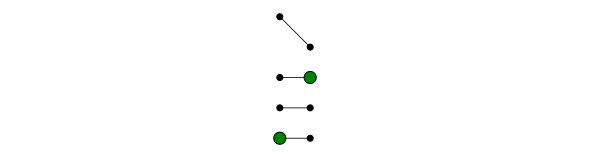

In [15]:
s = """

qreg Z[1];

qreg A[1];
qreg Z1[1];
qreg q[1];
qreg A1[1];
cx Z[0],A[0];
"""
g=zx.sqasm(s)
zx.full_reduce(g)
zx.draw_matplotlib(g)

In [16]:
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)

no direct extraction
case 1


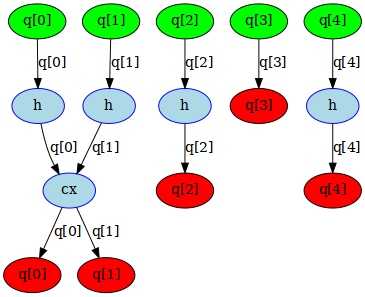

In [17]:
dag_drawer(d)

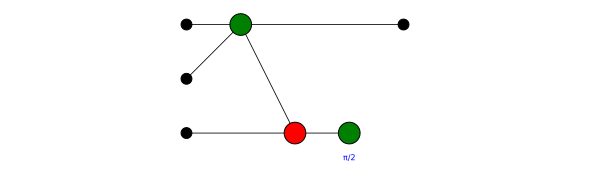

In [18]:
s = """
qreg q[1];
qreg Z[2];
cx q[0], Z[0];
cx q[0], Z[1];
s Z[1];
"""
g=zx.sqasm(s)
zx.draw_matplotlib(g)

no direct extraction
case 1


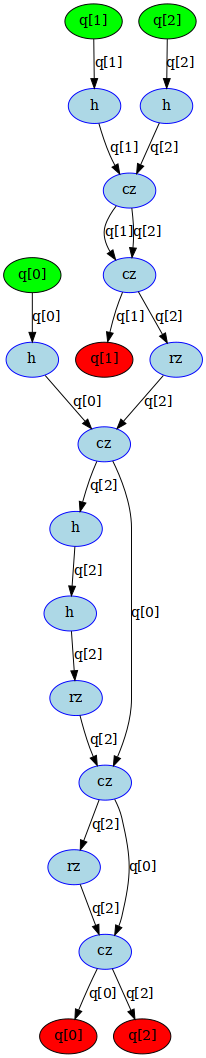

In [19]:
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)
dag_drawer(d)

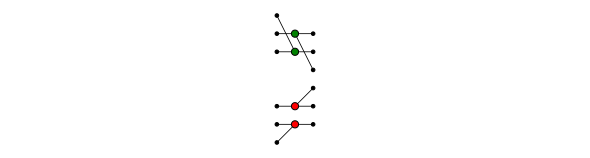

In [20]:
s = """

qreg Za[1];
qreg qa[2];

qreg Aa[1];
creg c[2];
cx qa[0], Aa[0]; // Z-copy
cx qa[1], Za[0]; // Z-merge

qreg Ab[1];
qreg qb[2];
qreg Zb[1];
cx Ab[0], qb[0]; // X-copy
cx Zb[0], qb[1]; // X-merge

"""
g=zx.sqasm(s)
zx.draw_matplotlib(g)

no direct extraction
case 1


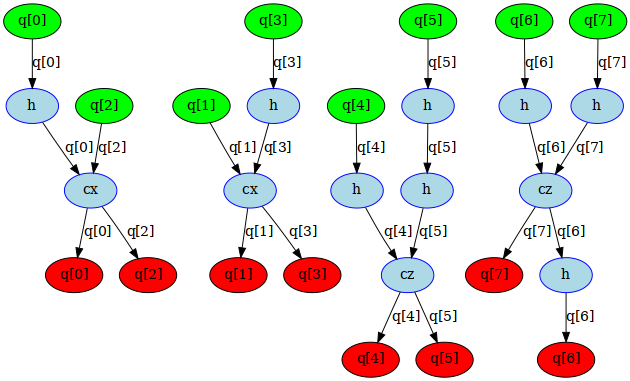

In [21]:
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)
dag_drawer(d)

case 3
HAD(0)
T(0)
HAD(0)
S*(1)
HAD(1)
S*(1)
HAD(2)
ZPhase(2,phase=3/4)
HAD(2)
S*(2)
HAD(3)
T(3)
CNOT(2,3)
HAD(2)
ZPhase(2,phase=7/4)


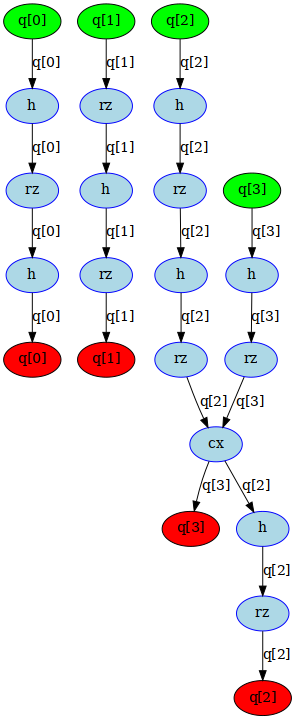

In [22]:
g=zx.generate.cliffordTmeas(4, 10, p_t=0.2, p_s=0.2, p_hsh=0.2, p_cnot=0.2, p_meas=0.2, backend=None)
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)
dag_drawer(d)

S(1)
S(2)
S(3)
CZ(2,3)
CNOT(1,2)
CNOT(2,1)
CNOT(1,2)


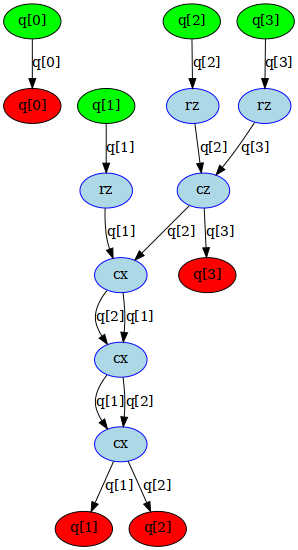

In [23]:
g=zx.generate.CNOT_HAD_PHASE_circuit(4, 15, p_had=0.2, p_t=0.2, clifford=True)
ob=ZXSwap()
d=ob.run(g)
# d=zx_to_dag(g)
dag_drawer(d)

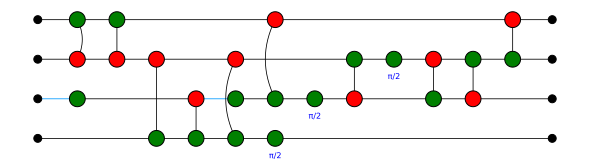

In [24]:
zx.draw_matplotlib(g)

In [25]:
from qiskit.transpiler import PassManager
from qiskit.transpiler import CouplingMap
from qiskit import BasicAer
pm = PassManager()

pm.append([ZXSwap()])

out_circ = pm.run(g)

Traceback (most recent call last):
  Input In [25] in <cell line: 8>
    out_circ = pm.run(g)
  File /opt/conda/lib/python3.8/site-packages/qiskit/transpiler/passmanager.py:231 in run
    return self._run_several_circuits(circuits, output_name, callback)
  File /opt/conda/lib/python3.8/site-packages/qiskit/transpiler/passmanager.py:264 in _run_several_circuits
    return parallel_map(
  File /opt/conda/lib/python3.8/site-packages/qiskit/tools/parallel.py:176 in parallel_map
    raise error
  File /opt/conda/lib/python3.8/site-packages/qiskit/tools/parallel.py:166 in parallel_map
    results = list(future)
  File /opt/conda/lib/python3.8/concurrent/futures/process.py:484 in _chain_from_iterable_of_lists
    for element in iterable:
  File /opt/conda/lib/python3.8/concurrent/futures/_base.py:619 in result_iterator
    yield fs.pop().result()
  File /opt/conda/lib/python3.8/concurrent/futures/_base.py:437 in result
    return self.__get_result()
  File /opt/conda/lib/python3.8/concurrent/